In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "model_training"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 모델 훈련
모델의 작동 방식을 잘 알고 있으면 적절한 모델, 올바른 훈련 알고리즘, 작업에 맞는 좋은 하이퍼 파라미터를 빠르게 찾을 수 있음

또한 작동 원리를 이해하면 디버깅이나 에러를 효율적으로 분석하는 데 도움이 됨

이 장의 대부분의 주제는 신경망을 이해하고 구축하고 훈련시키는 데 필수

가장 간단한 모델 중 하나인 **선형 회귀**부터 시작. 이 모델을 훈련시키는 두 가지 방법
1. 직접 계산할 수 있는 공식을 사용하여 훈련 세트에 잘 맞는 모델 파라미터(즉, 훈련 세트에 대해 비용 함수를 최소화하는 모델 파라미터)를 해석학적으로 구하기

2. 경사하강법(GD)라고 불리는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용함수를 훈련 세트에 대해 최소화(결국에는 위의 방법과 동일한 파라미터로 수렴)
- 경사 하강법의 변종으로 신경망에서 사용하게 될 **배치 경사 하강법**, **미니배치 경사 하강법**, **확률적 경사 하강법**도 살펴 볼 예정

그 이후에는 비선형 데이터셋에 훈련시킬 수 있는 조금 더 복잡한 모델인 **다항 회귀** 탐색(이 모델은 선형 회귀보다 파라미터가 더 많아서 훈련 데이터에 과대적합되기 더 쉬움)

따라서  학습 곡선을 사용해서 **모델이 과대적합되는지 감지**하는 방법도 탐색할 예정

그 후, 훈련 세트의 과대적합을 감소시킬 수 있는 **규제** 기법을 탐색

마지막으로 분류 작업에 널리 사용되는 모델인 **로지스틱 회귀**와 **소프트맥스 회귀** 탐색

In [2]:
import numpy as np
X = 2* np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

그림 저장: generated_data_plot


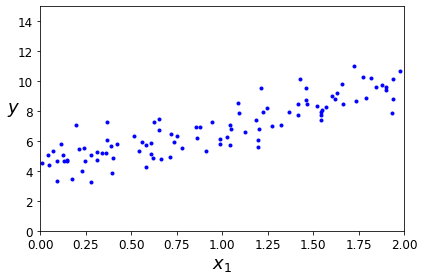

In [6]:
plt.plot(X,y,'b.')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.axis([0,2,0,15])
save_fig('generated_data_plot')
plt.show()

**정규 방정식**

$
\boldsymbol{\hat{\theta}=(X^{T}X)^{-1}X^{T}y}
$

**정규방정식**을 통해 theta_hat 계산

넘파이 선형대수 모듈(`np.linalg`)에 있는 `inv()` 함수를 사용해서 역행렬 구하고 `dot()` 메서드를 사용해서 행렬 곱셈 수행

In [8]:
X_b = np.c_[np.ones((100,1)),X] # 모든 샘플에 x0 = 1 추가

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [9]:
theta_best

array([[4.21509616],
       [2.77011339]])

$ \hat{y} = \mathbf{X} \hat{\theta}$

In [10]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

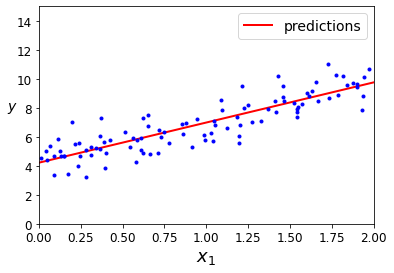

In [17]:
plt.plot(X_new, y_predict,"r-", linewidth = 2, label = 'predictions')
plt.plot(X,y,"b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 14)
plt.legend(loc = "best", fontsize = 14)
plt.axis([0,2,0,15])
plt.savefig("linear_model_predictions_plot")
plt.show()

## 사이킷런을 이용한 선형회귀

In [18]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [19]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`LinearRegression` 클래스는 `scipy.linalg.lstsq()` 함수를 사용하므로 이 함수를 직접 사용할 수 있음

In [23]:
theta_best_svd, residuals,rank,  s = np.linalg.lstsq(X_b,y,rcond=1e-6)
theta_best_svd
# residual = (yhat-y)**2


array([[4.21509616],
       [2.77011339]])

위의 함수는 $\hat{\theta} = \mathbf{X}^{+} \mathbf{y} $($\boldsymbol{X^{+}}$는 $\boldsymbol{X}$의 유사 역행렬) 계산
- 정확하게는 $ \mathbf{X}^{+} $는 Moore-Penrose inverse matrix

`np.linalg.pinv()` 함수를 이용해 유사역행렬을 직접 구할 수 있다

$ \hat{\theta} = \mathbf{X}^{-1} \hat{y}$

In [26]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 배치 경사 하강법을 사용한 선형 회귀

In [24]:
from IPython.display import Image

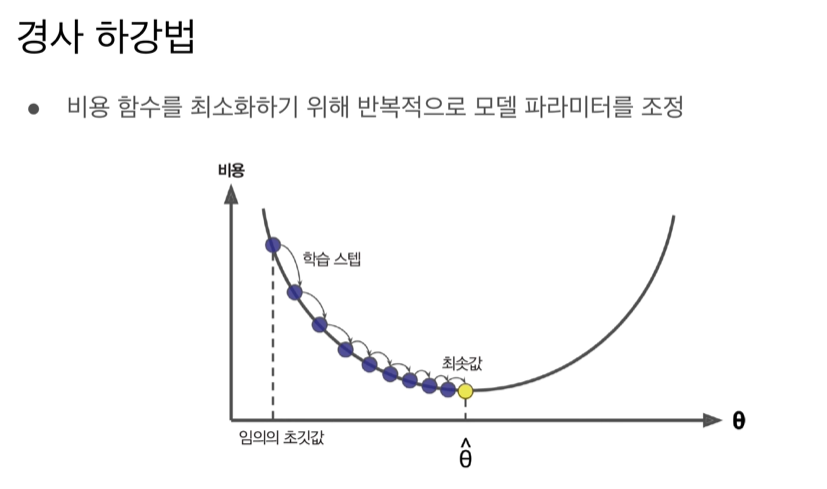

In [25]:
Image("pic_modeltrain/1.png")

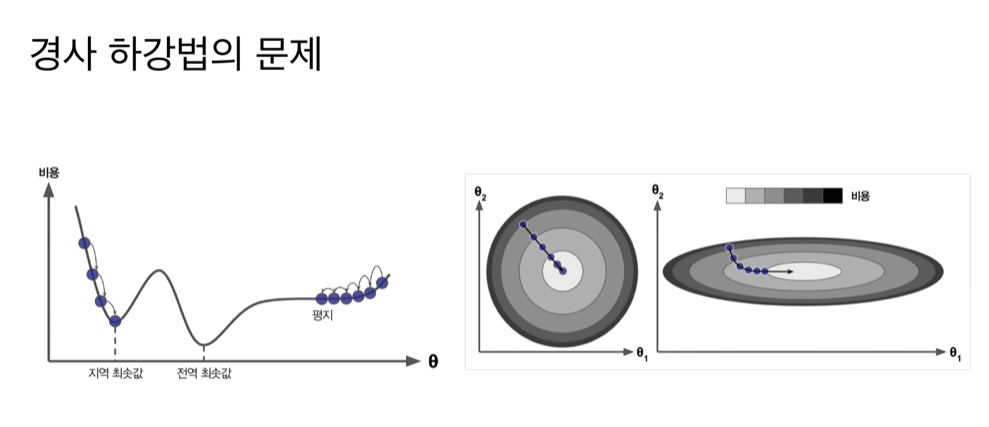

In [27]:
Image("pic_modeltrain/2.png")

- 경사하강법의 문제로 다소 복잡한 비용함수에서 전역 최솟값에 도달하지 못하고 지역 최솟값에 갇히거나 평지에 갇히는 경우가 있음
- 특성 간의 scale이 맞지 않는 경우에는 최솟값을 찾는 과정이 비효율적일 수 있음

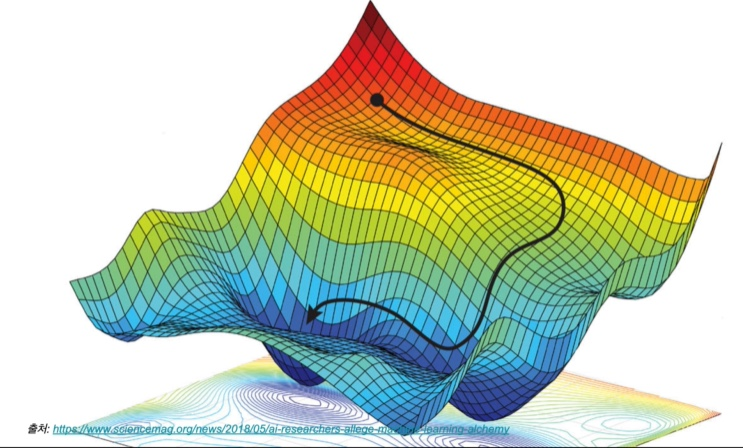

In [28]:
Image("pic_modeltrain/3.jpg")

**비용 함수의 그레이디언트 벡터**

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$

**경사 하강법의 스텝**

$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
$

$ \eta $는 학습률이며 임의의 값이기 때문에 직접 설정해줘야 함
- 학습률이 너무 작으면 알고리즘이 수렴하기 위해서 반복을 많이 진행해야 하기 때문에 시간이 오래 걸린다
- 학습률이 너무 크면 알고리즘이 수렴하지 않을 가능성이 있다

경사하강법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 함(예를 들면 사이킷런의 `StandardScaler`를 사용)

그렇지 않으면 수렴하는 데 훨씬 오래 걸린다

In [34]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)

for iterations in range(n_iterations) :
    gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta * gradients

In [35]:
theta

array([[4.21509616],
       [2.77011339]])

In [36]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [37]:
theta_path_bgd = []

def plot_gradient_descent(theta,eta,theta_path = None) : 
    m = len(X_b)
    plt.plot(X,y,"b.")
    n_iterations = 1000
    for iterations in range(n_iterations) :
        if iterations < 10 :   # 초기 10번에 대해서만 plot 그리기
            y_predict = X_new_b.dot(theta)
            style = 'b-' if iterations > 0 else 'r--'
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta* gradients
        if theta_path is not None :
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize = 18)
    plt.axis([0,2,0,15])
    plt.title(r"$\eta = {}$".format(eta), fontsize = 16)

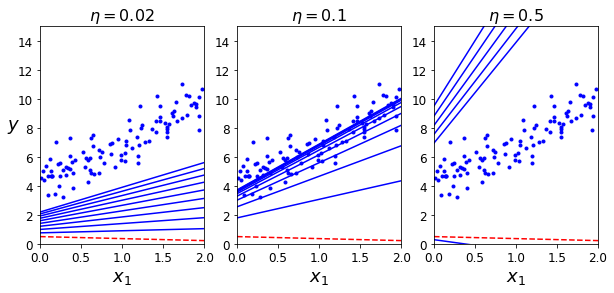

In [39]:
np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize = (10,4))
plt.subplot(131) ; plot_gradient_descent(theta, eta = 0.02)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.subplot(132) ; plot_gradient_descent(theta, eta = 0.1, theta_path = theta_path_bgd)
plt.subplot(133) ; plot_gradient_descent(theta, eta = 0.5)

plt.savefig("gradient_descent_plot")
plt.show()

# 확률적 경사 하강법

**배치 경사 하강법**의 가장 큰 문제는 매 스텝에서 전체 훈련 세트를 사용해서 그레이디언트를 계산한다는 사실이다
- 훈련 세트가 커지면 시간이 아주 오래 걸림

이와는 반대로 **확률적 경사 하강법**은 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레이디언틀르 계산
- 매 반복에서 다뤄야 할 데이터가 매우 적기 때문에 한 번에 하나의 샘플을 처리하면 알고리즘이 확실히 훨씬 빨라진다
- 또한 매 반복에서 하나의 샘플만 메모리에 있으면 되기 때문에 매우 큰 훈련 세트도 훈련시킬 수 있다(SGD는 외부 메모리 학습 알고리즘으로 구현할 수 있다)

반면에 **확률적**(즉, 무작위)이므로 이 알고리즘은 배치 경사 하강법보다 훨씬 **불안정**하다

비용 함수가 최솟값에 도달할 때까지 부드럽게 감소하지 않고 위아래로 변동이 생기면서 평균적으로 감소하게 된다
- 시간이 지나면 최솟값에 매우 근접하겠지만 요동이 지속되면서 최솟값에 안착하지 못 할 것이다
- 알고리즘이 멈출 때 좋은 값이 구해지겠지만 최적의 값은 아니다

무작위성은 지역 최솟값에서 탈출시켜준다는 점에서는 좋지만 반대로 전역 최솟값에 다다르지 못하게 한다는 점에서는 좋지 않다

이 딜레마를 해결하는 한 가지 좋은 방법은 **학습률을 점진적으로 감소시키는 것**이다

시작할 때는 학습률을 크게 해서 빠르게 수렴하도록 하면서 지역 최솟값에 빠지지 않게 하다가 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하도록 한다

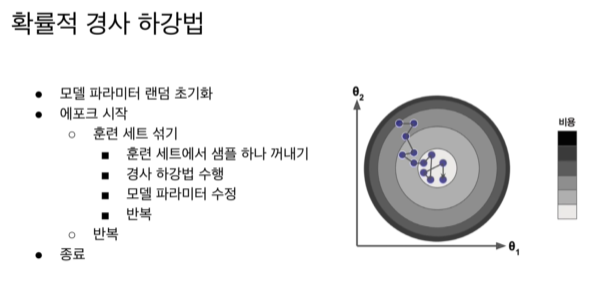

In [40]:
Image("pic_modeltrain/4.png")

간단한 학습 스케줄을 사용한 확률적 경사 하강법의 구현

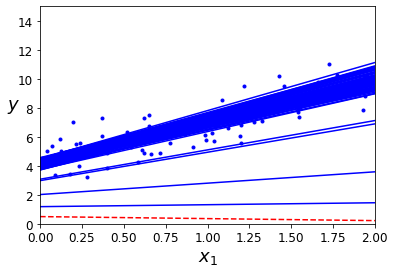

In [43]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)
n_epochs = 50
t0, t1 = 5,50

def learning_schedule(t):
    return t0 / (t + t1)    
 
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20 : # 확률적 경사 하강법의 첫 20번째 스텝
            y_predict = X_new_b.dot(theta)
            style = 'b-' if i > 0 else 'r--'
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) -yi) #  m = 1이기 때문
        # 최적값으로 가까워질수록 변동폭을 줄이기 위해 학습할수록 𝜂값 줄이기
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)
        
plt.plot(X,y,'b.')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize= 18)
plt.axis([0,2,0,15])
plt.savefig('sgd_plot')
plt.show()

In [48]:
theta

array([[4.21076011],
       [2.74856079]])

In [49]:
from sklearn.linear_model import SGDRegressor
#learning_rate = 'invscaling', eta0/t**0.25, 'constant', 'optimal', 'adaptive'
sgd_reg = SGDRegressor(max_iter = 1000 , tol = 1e-3 , penalty = None, eta0 = 0.1 , random_state = 42)
sgd_reg.fit(X,y.ravel())  #ravel 함수를 이용해서 2차원 배열을 1차원 배열로 만들어줌

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [50]:
sgd_reg.intercept_ , sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

# 미니배치 경사 하강법
배치 경사 하강법과 확률적 경사 하강법의 중간

각 스텝에서 (배치 경사 하강법처럼) 전체 훈련 세트나 (확률적 경사 하강법처럼)하나의 샘플을 기반으로 그레이디언트를 계산하는 것이 아니라 **미니배치**라 부르는 임의의 작은 샘플 세트(2의 배수)에 대해서 그레이디언트를 계산

확률적 경사 하강법에 비해 미니배치 경사 하강법의 주요 장점은 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 얻는 성능 향상

특히 미니배치를 어느 정도 크게 만들어주면 이 알고리즘은 파라미터 공간에서 SGD보다 덜 불규칙하게 움직인다

결국 미니배치 경사 하강법이 SGD보다 최솟값에 더 가까이 도달하게 될 것이다

하지만 지역 최솟값에서 빠져나오기는 더 힘들 수도 있다

In [51]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [52]:
theta

array([[4.25214635],
       [2.7896408 ]])

**세 가지 경사 하강법 알고리즘이 파라미터 공간에서 움직인 경로**

In [53]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

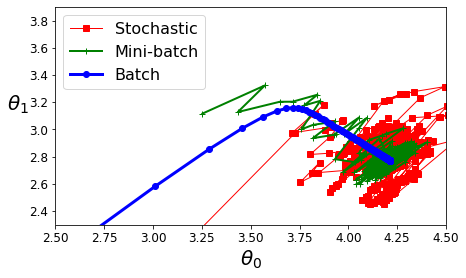

In [54]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.savefig("gradient_descent_paths_plot")
plt.show()

모두 최솟값 근처에 도달했지만 배치 경사 하강법의 경로가 실제로 최솟값에서 멈춘 반면 확률적 경사 하강법와 미니배치 경사 하강법은 근처에서 맴돌고 있음

그렇지만 배치 경사 하강법에서는 매 스텝에서 많은 시간이 소요되고 확률적 경사 하강법과 미니배치 경사 하강법도 적절한 학습 스케줄을 사용하면 최솟값에 도달ㅡ

**확률적 경사하강법**의 경우 **변동이 심하다**

**미니배치 경사하강법**의 경우 **변동이 상대적으로 작고 빠르게 최적점을 찾아감**

**배치 경사하강법**의 경우 **모든 데이터를 사용**하기 때문에 **변동이 작고 빠르게 찾아감**

- 결과의 측면에서는 배치 경사하강법이 가장 바람직하지만 데이터의 양이 아주 방대한 경우가 많기 때문에 사용하기 어려운 경우가 종종 있음
- 대안으로 미니배치 경사하강법을 사용하는 경우가 많다

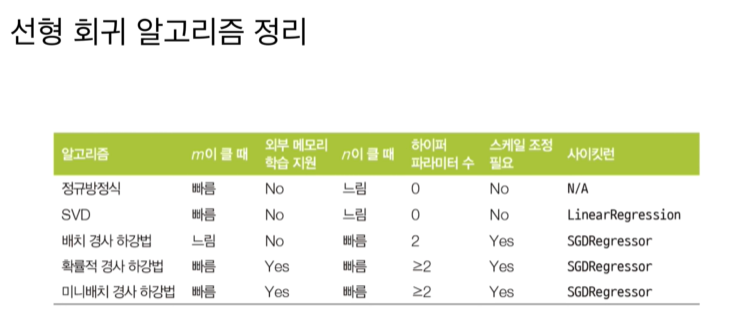

In [55]:
Image("pic_modeltrain/5.png")

# 다항 회귀

가지고 있는 데이터가 단순한 직선보다 복잡한 비선형 데이터라도 이런 데이터를 학습하는 데 선형 모델을 사용할 수 있다

이렇게 하는 간단한 방법은 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것

이런 기법을 **다항 회귀**(polynomial regression)이라고 한다

간단한 **2차 방정식** 예제

In [56]:
import numpy as np
import numpy.random as rnd
np.random.seed(42)

In [57]:
m = 100
X = 6 * np.random.rand(m,1) - 3  # U(-3,3)에서 100개의 sample 추출
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1) # 1/2x^2 + x + 2 에 노이즈 추가

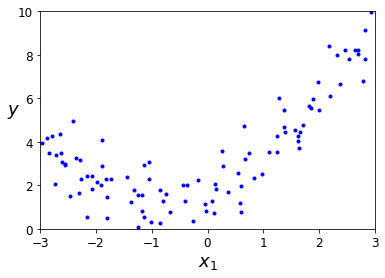

In [58]:
import matplotlib.pyplot as plt

plt.plot(X,y,'b.')
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0 , fontsize = 18)
plt.axis([-3,3,0,10])
plt.savefig("quadratic_data_plot")
plt.show()

In [59]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
# include_bias = True가 기본값, 편향을 위한 특성 1 
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [60]:
X_poly[0] # x와 x^2 출력

array([-0.75275929,  0.56664654])

In [61]:
poly_features.get_feature_names() # 어떤 특성으로 구성되어 있는지 확인

['x0', 'x0^2']

X_poly는 이제 원래 특성 X와 이 특성의 제곱을 포함

이 확장된 훈련 데이터에 LinearRegression을 적용

In [62]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

fit_intercept = False 옵션 추가한 경우

In [63]:
lin_reg2 = LinearRegression(fit_intercept = False)
lin_reg2.fit(X_poly,y)
lin_reg2.intercept_, lin_reg.coef_

(0.0, array([[0.93366893, 0.56456263]]))

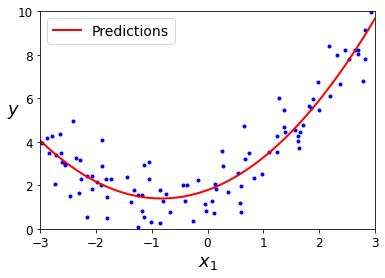

In [64]:
X_new = np.linspace(-3,3,100).reshape(100,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X,y,'b.')
plt.plot(X_new,y_new,'r-',linewidth=2, label = 'Predictions')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.legend(loc='upper left', fontsize = 14)
plt.axis([-3,3,0,10])
plt.savefig('quadratic_predictions_plot')
plt.show()

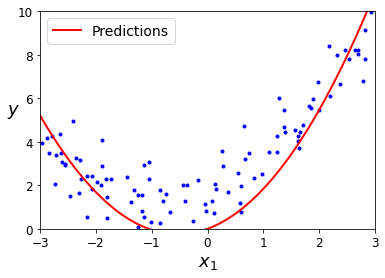

In [65]:
X_new = np.linspace(-3,3,100).reshape(100,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg2.predict(X_new_poly)
plt.plot(X,y,'b.')
plt.plot(X_new,y_new,'r-',linewidth=2, label = 'Predictions')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.legend(loc='upper left', fontsize = 14)
plt.axis([-3,3,0,10])
plt.savefig('quadratic_predictions_plot_silly')
plt.show()

**과대적합 vs 과소적합**

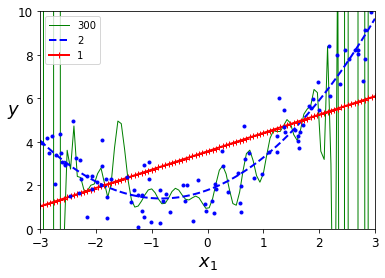

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler), 
            #차원이 높아지면 값의 변동이 커지기 때문에 회귀 모형임에도 std_scaler적용
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.savefig("high_degree_polynomials_plot")
plt.show()

# 학습 곡선
과대적합, 과소적합을 판단하는 그래프 중 하나로 **학습 곡선(learning curve)**이 있음

학습 곡선은 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타냄

이 그래프를 생성하기 위해서는 단순히 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러 번 훈련시키면 된다

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14) 
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

## 단순 회귀(과소 적합)

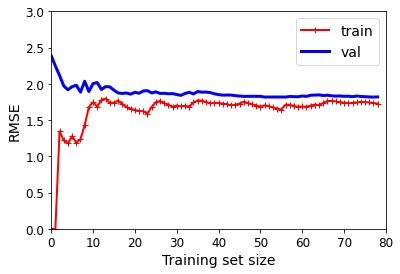

In [68]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                        
plt.savefig("underfitting_learning_curves_plot")  
plt.show()                                      

**훈련 세트**에 샘플이 추가됨에 따라서 잡음이 존재하고 비선형이기 때문에 완벽하게 학습하는 것이 불가능해지면서 오차가 계속 상승(어느 정도 평편해질 때까지)

그 이후로는 훈련 세트에 샘플이 추가되어도 평균 오차가 크게 나아지거나 나빠지지 않는다

**검증 데이터**의 경우 적은 수의 샘플로 훈련할 때는 잏반화할 수 없기 때문에 오차가 매우 크다가 서서히 감소한다

하지만 선형 회귀의 직선은 데이터를 잘 모델링할 수 없기 때문에 오차의 감소가 완만해져서 훈련 세트의 그래프와 가까워짐

이 학습이 과소적합 모델의 전형적인 모습인데 **두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접**해 있다

## 10차 다항 회귀(과대 적합)

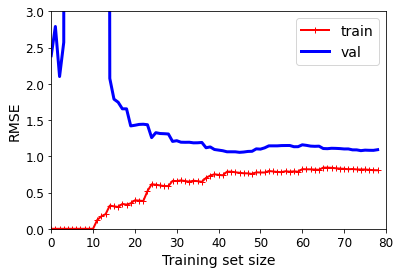

In [69]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])          
plt.savefig("learning_curves_plot")  
plt.show()                        

훈련 데이터의 오차가 단순회귀 모형보다 **훨씬 낮다**

두 곡선 사이에 다소 넓은 공간이 있다. 즉, 훈련 데이터에서의 모델 성능이 검증 데이터보다 훨씬 낫다는 것이고 이것이 **과대적합** 모델의 특징이다
- **더 큰 훈련 세트**를 사용하면 두 곡선이 점점 가까워진다

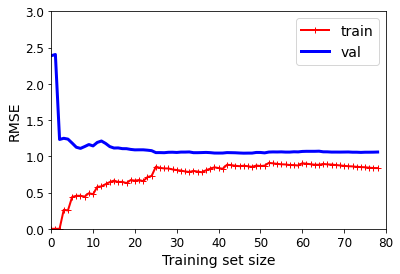

In [70]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree = 2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])          
plt.savefig("desirable_learning_curves_plot")  
plt.show()                        

# 규제가 있는 모델

과대적합을 감소시키는 좋은 방법은 모델을 **규제**하는 것

자유도를 줄이면 데이터에 과대적합되기 더 어려워지는데, 다항 회귀 모델을 규제하는 간단한 방법은 다항식의 **차수를 감소**시키는 것

선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가한다

## 릿지 회귀
$l_2$ 노름의 제곱을 손실 함수에 추가해서 가중치가 커지는 것을 막음

즉, 규제항 $\alpha\sum\limits_{i=1}^{n}\theta_i^{2}$이 비용 함수에 추가된다(모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 평가)

이는 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 한다

릿지 회귀는 입력 특성의 스케일에 민감하기 때문에 수행하기 전에 데이터의 스케일을 맞추는 것이 중요(ex.`StandardScaler`)
- 규제가 있는 모델은 대부분 이런 특성을 가짐

**릿지 회귀의 비용 함수**

$
\text{J}(\boldsymbol{\theta})
 = \text{MSE}(\boldsymbol{\theta}) + \boldsymbol{\alpha} \dfrac{1}{2} \sum \limits_{i=1}^{n}{\theta_i}^2
$

$\alpha$는 모델을 얼마나 많이 규제할지 조절

$\alpha$가 크면 손실값이 커지므로 모든 가중치가 거의 0에 가까워짐

In [77]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [78]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1 , solver = 'cholesky', random_state = 42) 
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

solver = 'sag'

In [79]:
ridge_reg = Ridge(alpha = 1 , solver = 'sag', random_state = 42) 
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

solver = 'saga'

In [80]:
ridge_reg = Ridge(alpha = 1 , solver = 'saga', random_state = 42) 
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55077902]])

$\alpha$값에 따른 모델 훈련 결과 비교

선형 회귀(왼쪽) vs 다항 회귀(오른쪽)

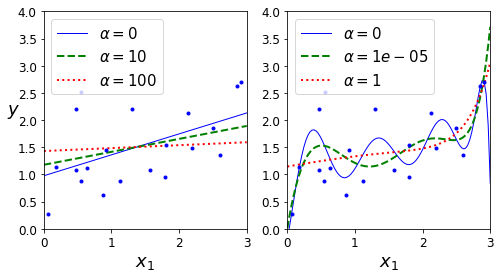

In [81]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.savefig("ridge_regression_plot")
plt.show()

**릿지 회귀의 정규방정식**

$ \hat{\theta} = (\mathbf{X}^{T}\mathbf{X}+\alpha\mathbf{A})^{-1}\mathbf{X}^{T}\mathbf{y} $

선형회귀에서 규제가 커질수록 각 특성에 대한 가중치가 줄어들기 때문에 **기울기가 낮아지고** **수평선에 가까운 형태**로 변하고 있음

다항회귀에서는 **규제가 강할수록 모델의 복잡도가 낮아짐**을 알 수 있다

**확률적 경사하강법**을 사용

In [82]:
sgd_reg = SGDRegressor(penalty = "l2", max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

penalty 매개변수는 사용할 규제를 지정하는데 "l2"는 SGD가 **비용 함수에 가중치 벡터의 $l_2$노름의 제곱을 2로 나눈 규제항을 추가**하게 만든다

즉, **릿지 회귀**와 같다

## 라쏘 회귀
$l_1$노름을 사용

**라쏘 회귀의 비용 함수**

$J({\theta})=MSE(\boldsymbol{\theta})+\alpha\sum \limits_{i=1}^{n}|\theta_i|$

선형회귀의 비용 함수에 가중치 벡터의 $l_1$ 노름을 더해준 값을 비용함수로 사용

다양한 수준의 라쏘 규제를 사용한 선형 회귀(왼쪽)과 다항 회귀(오른쪽)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827432, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


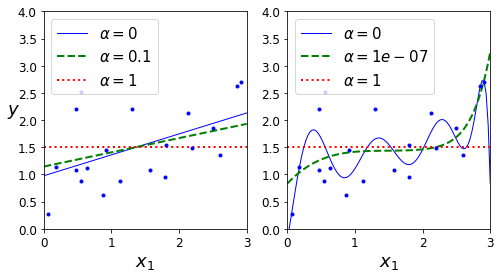

In [83]:
from sklearn.linear_model import Lasso
plt.figure(figsize = (8,4))
plt.subplot(121)
plot_model(Lasso, polynomial = False, alphas=(0, 0.1, 1), random_state = 42) 
plt.ylabel("$y$", rotation=0, fontsize = 18)
plt.subplot(122)
plot_model(Lasso, polynomial = True, alphas= (0,10**-7,1), random_state = 42)
plt.savefig('lasso_regression_plot')
plt.show()

왼쪽의 그림에서 $\alpha$가 0일 때는 상대적으로 기울기가 크고 $\alpha$가 1인 경우에는 가중치가 0이 돼서 수평선이 되었음

오른쪽의 그림에서도 $\alpha$가 0일 때는 복잡도가 높지만 $\alpha$가 1인 경우에는 가중치가 0이 돼서 수평선이 되었음

In [88]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.53788174])

라쏘 회귀의 중요한 특징은 덜 중요한 특성의 가중치를 제거하려고 한다는 점(즉, 가중치가 0이 됨)

다시 말해, 라쏘 회귀는 자동으로 특성 선택을 하고 희소 모델을 만든다(즉, 0이 아닌 특성의 가중치가 작아진다)

## 엘라스틱넷

릿지 회귀와 라쏘 회귀를 **절충한 모델**

규제항은 릿지와 라쏘의 규제항을 단순히 더해서 사용하며 혼합 정도는 **혼합 비율 $r$을 통해서 조절**

$r=0$이면 엘라스틱넷은 릿지 회귀와 같고 $r=1$이면 라쏘 회귀와 같다
- 사이킷런의 Lasso 클래스는 $l_1$\_ratio = 1.0인 ElasticNet 클래스를 사용한다. 하지만 $l_1$\_ratio = 0인 ElasticNet과 Ridge  클래스는 서로 다름

**엘라스틱넷 비용 함수**

$J(\theta) = MSE(\theta) + r\alpha\sum \limits_{i=1}^{n}|\theta_i|+ \dfrac{1-r}{2} \alpha\sum \limits_{i=1}^{n}\theta_i^{2}$

## 규제가 없는 선형 회귀, 릿지, 라쏘, 엘라스틱넷을 언제 사용하는 것이 좋은가? 
어느 정도 규제가 있는 것이 대부분의 경우에 좋으므로 **규제가 없는 선형 회귀는 피하는 것이 좋음**

*경험적으로* **릿지나 엘라스틱넷이 선호**

**쓰이는 특성이 몇 개뿐이라고 의심**되면 **라쏘나 엘라스틱넷이 더 나음**
- 이 모델들은 불필요한 특성의 가중치를 0으로 만들어줌
- **특성 수가 훈련 샘플 수보다 많거나** **특성 몇 개가 강하게 연관**되어 있을 때는 보통 라쏘가 문제를 일으키므로 **엘라스틱넷 선호**
- **라쏘**는 **특성 수가 샘플 수보다 많으면 최대 샘플 수만큼의 특성을 선택**. 또한 **여러 특성이 강하게 연관되어 있으면 이들 중 임의의 특성을 하나 선택**

In [89]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5, random_state = 42)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([1.54333232])

## 조기 종료
경사 하강법과 같은 반복적인 학습 알고리즘을 구현하는 방식 중 하나는 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것인데 이를 **조기 종료**라고 한다

에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측 에러(RMSE)와 검증 세트에 대한 예측 에러가 줄어들다가 감소하던 검증 에러가 다시 상승하는데, 이것은 모델이 훈련 데이터에 과대적합되기 시작했다는 것을 의미

조기 종료는 검증 에러가 최소에 도달하는 즉시 훈련을 멈추는 것

In [98]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [99]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

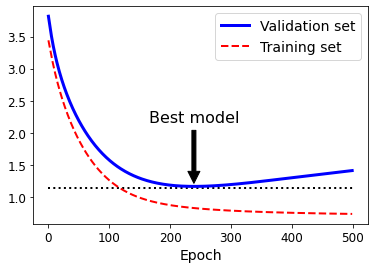

In [100]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.savefig("early_stopping_plot")
plt.show()

- 위의 그림은 배치 경사 하강법으로 훈련시킨 고차원 다항 회귀 모델(복잡한 모델)
- 에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측 에러(RMSE)와 검증 세트에 대한 예측 에러 감소
- 그렇지만 감소하던 검증 에러가 다시 상승하는데, 이는 모델이 훈련 데이터에 과대적합되기 시작했다는 것을 의미
- 조기 종료는 검증 에러가 최소에 도달하는 즉시 훈련을 멈춤

In [93]:
best_epoch, minimum_val_error, best_model

(239,
 1.351311051245387,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

In [94]:
sgd_reg = SGDRegressor(penalty = None, learning_rate = 'constant', eta0 = 0.0005, random_state = 42,
                      early_stopping =True)
sgd_reg.fit(X_train_poly_scaled, y_train)
y_val_predict = sgd_reg.predict(X_val_poly_scaled)
mean_squared_error(y_val, y_val_predict),sgd_reg.n_iter_

(0.8987688364730185, 293)

In [95]:
import matplotlib.pyplot as plt
import numpy as np

In [96]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

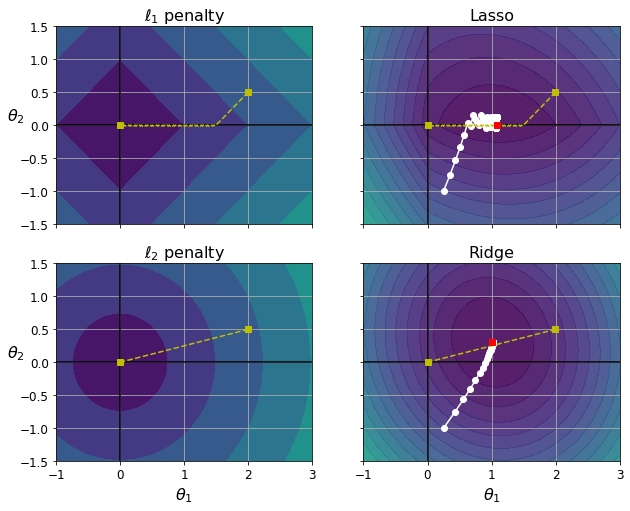

In [97]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.savefig("lasso_vs_ridge_plot")
plt.show()

두 축은 모델 파라미터 두 개를 나타내고 배경의 등고선은 각기 다른 손실 함수를 나타낸다

왼쪽 위 그래프의 등고선은 $l_1$손실 ($|\theta_1|+|\theta_2|$)를 나타내는데, 축에 가까워지면서 선형적으로 줄어든다

예를 들어 모델 파라미터를 $\theta_1$=2, $\theta_2$=0.5로 초기화하고 경사 하강법을 실행하면 두 파라미터가 동일하게 감소된다(노란 점선)

따라서 $\theta_2$가 먼저 0에 도달($\theta_2$가 시작할 때 0에 더 가깝기 때문)

그 다음 경사 하강법이 $\theta_1$=0에 도달할 때까지 축을 따라 내려갔다($l_1$의 그레이디언트는 0에서 정의되지 않기 때문에 진동이 발생, 이 지점에서 그레이디언트는 -1 또는 1)



오른쪽 위 그래프의 등고선은 라쏘 손실 함수를 나타낸다(즉, $l_1$ 손실을 더한 MSE 손실 함수)

하얀 작은 원이 경사 하강법이 $\theta_1$=0.25, $\theta_2$ =-1로 초기화된 모델 파라미터를 최적화하는 과정을 보여준다

여기서도 $\theta_2$=0으로 빠르게 줄어ㅈ들고 그 다음 축을 따라 진동하면서 전역 최적점(빨간 사각형)에 도달

$\alpha$가 증가하면 전역 최적점이 노란 점선을 따라 왼쪽으로 이동하고 감소하면 오른쪽으로 이동한다

아래 두 개의 그래프도 동일하지만 $l_2$ 패널티를 사용하는데, 왼쪽 아래 그래프에서 $l_2$ 손실은 원점에 가까울수록 줄어드는 것을 볼 수 있다

따라서 경사 하강법이 원점까지 직선 경로를 따라간다

오른쪽 아래 그래프의 등고선은 릿지 회귀의 비용 함수를 나타낸다(즉, $l_2$손실을 더한 MSE 손실 함수)

라쏘와 다른 점은 크게 두 가지

1. 파라미터가 전역 최적점에 가까워질수록 그레이디언트가 작아진다. 따라서 경사하강법이 자동으로 느려지고 수렴에 도움이 된다
2. $\alpha$를 증가시킬수록 최적의 파라미터(빨간 사각형)가 원점에 더 가까워진다. 하지만 완전히 0이 되지는 않는다

## 로지스틱 회귀

로지스틱 회귀는 샘플이 특정 클래스에 속할 확률을 추정하는 데 널리 사용된다

확률 추정
- 선형 회귀 모델과 같이 로지스틱 회귀 모델은 입력 특성의 가중치 합을 계산(그리고 편향을 더함)
- 대신 선형 회귀처럼 **바로 결과를 출력하지 않고** **결괏값의 로지스틱을 출력**   

**로지스틱 회귀 모델의 확률 추정(벡터 표현식)**

$
\hat{p} = h_\theta(\boldsymbol{x}) = \sigma(\theta^{T}\boldsymbol{x})
$


로지스틱($\sigma$로 표시)은 0과 1 사이의 값을 출력하는 시그모이드 함수

**로지스틱 함수**

$
\sigma(t) = \dfrac{1}{1+exp(-t)}
$

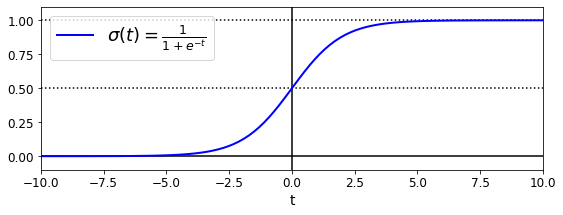

In [3]:
t = np.linspace(-10,10,100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize = (9,3))
plt.plot([-10,10],[0,0],'k-')
plt.plot([-10,10],[0.5,0.5],'k:')
plt.plot([-10,10],[1,1],'k:')
plt.plot([0,0],[-1.1,1.1],'k-')
plt.plot(t,sig,'b-', linewidth = 2, label = r"$\sigma(t) = \frac{1}{1+e^{-t}}$")
plt.xlabel('t')
plt.legend(loc = 'upper left', fontsize = 18)
plt.axis([-10,10,-0.1,1.1])
plt.savefig('logistic_function_plot')
plt.show()

**로지스틱 회귀 모델 예측**

$
\hat{y} =
\begin{cases}
  0 & \hat{p}<0.5\text{일 때}\\
  1 & \hat{p}>=0.5\text{일 때},
\end{cases}
$

**하나의 훈련 샘플에 대한 손실 함수**

$
c(\theta) = 
\begin{cases}
-log(\hat{p}) & \text{if } y = 1, \\
-log(1-\hat{p}) & \text{if } y = 0,
\end{cases}
$

**로지스틱 회귀 비용 함수(로그 손실)**

$
J(\theta) = -\dfrac{1}{m}\sum \limits_{i=1}^{m}[y^{(i)}log(\hat{p}^{(i)})+(1-y^{(i)})log(1-\hat{p}^{(i)})]
$

**로지스틱 비용 함수의 편도함수**

$
\dfrac{\partial}{\partial\theta_j}J(\theta) = \dfrac{1}{m}\sum \limits_{i=1}^{m} (\sigma(\theta^{T}\boldsymbol{x}^{(i)})
-y^{(i)})x_j^{(i)}
$

## Iris Data

In [4]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

**꽃잎의 너비를 기반으로 Iris-Versicolor 종을 감지하는 분류기 만들기**

In [5]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [6]:
np.unique(iris.target, return_counts=True) #0,1,2 각각의 target이 50개씩 있음을 확인

(array([0, 1, 2]), array([50, 50, 50], dtype=int64))

꽃잎의 너비를 기반으로 Iris-Versicolor 종을 감지하는 분류기

In [7]:
X = iris['data'][:,3:] #꽃잎 너비 #2차원 배열으로 만들기 위해서 [:,3:]
y = (iris['target']==2).astype(np.int) # Iris virgicolor이면 1 아니면 0

In [8]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver = 'lbfgs', random_state = 42)
log_reg.fit(X,y)

LogisticRegression(random_state=42)

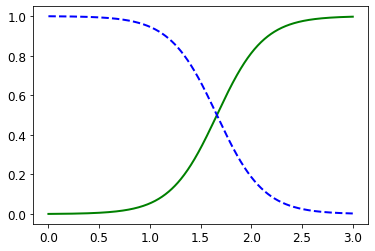

In [14]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new,y_proba[:,1], 'g-', linewidth = 2, label = 'Iris virginica')
plt.plot(X_new,y_proba[:,0], 'b--', linewidth = 2, label = 'Not Iris virginica')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


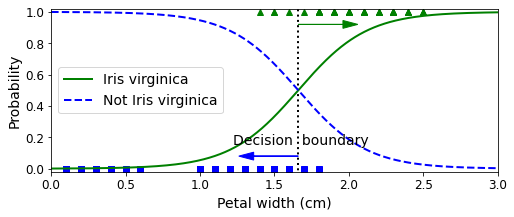

In [15]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.savefig("logistic_regression_plot")
plt.show()

In [16]:
decision_boundary

array([1.66066066])

In [17]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

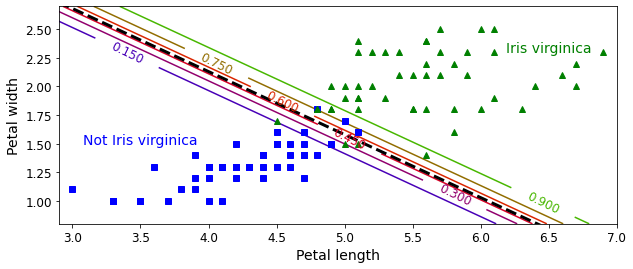

In [18]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

#x0 : 500구간이 200번 반복
#x1 : 200구간이 500번 반복
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
# 0 = coef_[0][0]*left_right + log_reg.intercept_[0][1]*너비 + 절편
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.savefig("logistic_regression_contour_plot")
plt.show()

점선은 모델이 50% 확률을 추정하는 지점으로 이 모델의 결정 경계

## 소프트맥스 회귀

로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있는데, 이를 **소프트맥스 회귀** 또는 **다항 로지스틱 회귀**라고 부른다

샘플 $\mathbf{x}$가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 $k$에 대한 점수 $s_k(\mathbf{x})$를 계산하고 그 점수에 소프트맥스 함수를 적용하여 각 클래스의 함수 추정

**소프트맥스 점수**

$
s_k(\mathbf{x})=(\theta^{(k)})^{T}\mathbf(x)
$

**소프트맥스 함수**

$
\hat{p}_k = \sigma(s(\boldsymbol{x}))_k = \dfrac{\text{exp}(s_k(\boldsymbol{x}))}{\sum \limits_{j=1}^{K}\text{exp}(s_j(\boldsymbol{x}))}
$

로지스틱 회귀 분류기와 마찬가지로 소프트맥스 회귀 분류기는 추정 확률이 가장 높은 클래스를 선택

**소프트맥스 회귀 분류기의 예측**

$
\hat{y}=arg_{_{_{k}}}max\sigma(\mathbf{s(x)})_k = arg_{_{_{k}}}maxs_k(\mathbf{x})=arg_{_{_{k}}}max((\theta^{(k)})^{T}\mathbf{x})
$

**크로스 엔트로피 비용 함수**

$
J(\theta) = -\dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}
y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)
$

**클래스 k에 대한 크로스 엔트로피의 그레이디언트 벡터**

$
\nabla_{\theta^{(k)}} = \dfrac{1}{m}\sum\limits_{i=1}^{m}(\hat{p}_k^{(i)}-y_k^{(i)})\boldsymbol{x}^{(i)}
$


In [24]:
X = iris['data'][:,(2,3)] # 꽃잎 길이, 꽃잎 너비
y = iris['target']

softmax_reg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C=10, random_state = 42)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

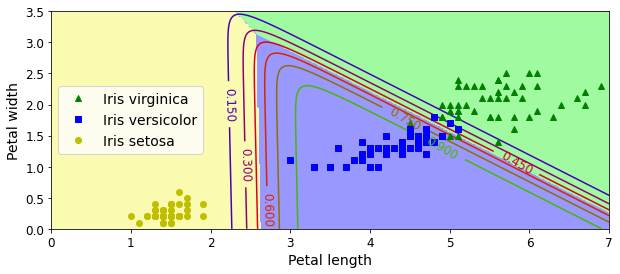

In [25]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.savefig("softmax_regression_contour_plot")
plt.show()

In [26]:
softmax_reg.predict([[5,2]])

array([2])

In [27]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])